In [1]:
import numpy as np
import png
import torch
from PIL import Image
import matplotlib.pyplot as plt

from Networks.UNetMini import Network
from Train import UNetMini as unet_config
from settings import DEVICE

In [2]:
IMAGE_PATH = "skku.jpg"
LABEL_PATH = "Datasets/Data/test_dev/ee616_0100.png"
CHECKPOINT_PATH = "Train/Results/UNetMini/Checkpoints/best_latest.pt"

SHOW_GROUND_TRUTH = False

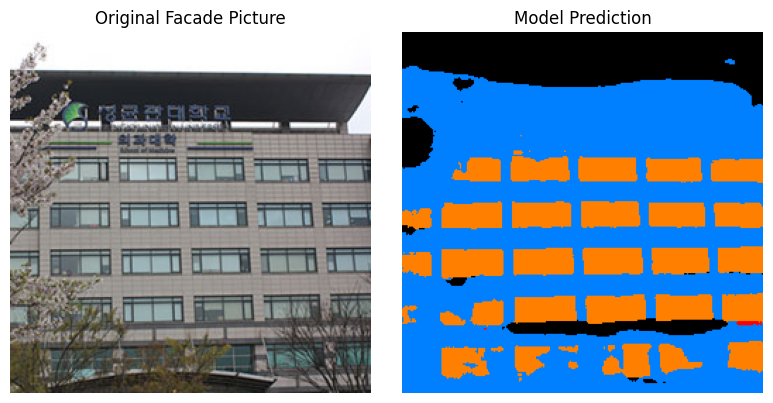

In [3]:
def load_palette(palette_path):
    reader = png.Reader(filename=palette_path)
    _, _, _, info = reader.read()
    palette = info.get("palette")
    return np.array(palette, dtype=np.uint8)


def colorize(mask, palette_array):
    colored = palette_array[mask]
    return colored


def preprocess_image(image_path, target_shape):
    img = Image.open(image_path).convert("RGB")
    _, h, w = target_shape
    if img.size != (w, h):
        img = img.resize((w, h))
    arr = np.asarray(img).astype("f").transpose(2, 0, 1) / 128.0 - 1.0
    return torch.from_numpy(arr).unsqueeze(0).float().to(DEVICE)


def load_checkpoint(model, ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    state = ckpt.get("model_state_dict", ckpt)
    model.load_state_dict(state)


palette = load_palette(LABEL_PATH)
image_tensor = preprocess_image(IMAGE_PATH, unet_config.INPUT_SHAPE)

model = Network(
    unet_config.INPUT_SHAPE,
    unet_config.OUTPUT_SHAPE[0],
    dim=unet_config.DIM,
    dropout=unet_config.DROPOUT,
).to(DEVICE)
load_checkpoint(model, CHECKPOINT_PATH)
model.eval()

with torch.no_grad():
    logits = model(image_tensor)
    pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

gt_png = Image.open(LABEL_PATH)
gt_mask = np.array(gt_png)

orig_img = Image.open(IMAGE_PATH).convert("RGB")


pred_color = colorize(pred_mask, palette)
gt_color = colorize(gt_mask, palette)

if SHOW_GROUND_TRUTH:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(orig_img)
    axes[0].set_title("Original Facade Picture")
    axes[1].imshow(gt_color)
    axes[1].set_title("Ground Truth")
    axes[2].imshow(pred_color)
    axes[2].set_title("Model Prediction")
else:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(orig_img)
    axes[0].set_title("Original Facade Picture")
    axes[1].imshow(pred_color)
    axes[1].set_title("Model Prediction")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.savefig("demo.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()